# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [33]:
import pandas as pd
import os
from os.path import isfile, join
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms


BASE = "./Dataset"
#BASE = "gdrive/MyDrive/Dataset"
cloth_folder = os.path.join(BASE, "Cloth Mask")
n95_folder = os.path.join(BASE, "N95")
n95valve_folder = os.path.join(BASE, "N95 mask with valve")
surgical_folder = os.path.join(BASE, "Surgical Mask")
without_mask_folder = os.path.join(BASE, "No Mask")
root_folder = ("./")



In [34]:
# predefined classes
classes = {
    "cloth": 0,
    "n95": 1,
    "n95valve": 2,
    "surgical": 3,
    "without_mask": 4
}


In [35]:
class FaceMaskDataset(Dataset):
    dataset = []
    conversion = None

    def __init__(self, images, indexes, conversion=transforms.ToTensor()):
        self.conversion = conversion
        self.dataset = images[int(indexes[0]):int(indexes[1])]
        
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        if self.conversion is not None:
            image = self.conversion(image)
        return image, self.dataset[index]['target']



In [36]:
# Load images from the dataset
def load_images():
  dat = []
  for filename in os.listdir(cloth_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(cloth_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['cloth']
        dat.append(sample)
    except:
        continue

  for filename in os.listdir(n95_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(n95_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['n95']
        dat.append(sample)
    except:
        continue

  for filename in os.listdir(n95valve_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(n95valve_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['n95valve']
        dat.append(sample)
    except:
        continue

  for filename in os.listdir(surgical_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(surgical_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['surgical']
        dat.append(sample)
    except:
        continue

  for filename in os.listdir(without_mask_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(without_mask_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['without_mask']
        dat.append(sample)
    except:
        continue

  return dat



In [37]:
train_split_percentage = 0.75
validation_split_percentage = 0.15
test_split_percentage = 0.1

#load images into memory
images = load_images()
random.shuffle(images)
size_of_the_dataset = len(images)
print("size_of_the_dataset", size_of_the_dataset)


batch_size = 25
num_of_classes = len(classes.keys())

train_indexes = [0, train_split_percentage * size_of_the_dataset]
validation_indexes = [train_split_percentage * size_of_the_dataset, (train_split_percentage + validation_split_percentage) * size_of_the_dataset]
test_indexes = [(train_split_percentage + validation_split_percentage) * size_of_the_dataset, size_of_the_dataset]


print(f"Effective train split = {train_indexes[0]} to {train_indexes[1]}")
print(f"Effective val split = {validation_indexes[0]} to {validation_indexes[1]}")
print(f"Effective test split = {test_indexes[0]} to {test_indexes[1]}")


size_of_the_dataset 2065
Effective train split = 0 to 1548.75
Effective val split = 1548.75 to 1858.5
Effective test split = 1858.5 to 2065


In [38]:
transform = transforms.Compose(
    [transforms.Resize((250, 250)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [39]:
print("Loading training set")
train_dataset = FaceMaskDataset(images, train_indexes, conversion=transform)

print("Loading validation set")
validation_dataset = FaceMaskDataset(images, validation_indexes, conversion=transform)

print("Train Dataset length ", len(train_dataset))
print("Validation Dataset length ", len(validation_dataset))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Loading training set
Loading validation set
Train Dataset length  1548
Validation Dataset length  310


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [41]:
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'validation_loss': loss.detach(), 'validation_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['validation_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'validation_loss': epoch_loss.item(), 'validation_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}"
              .format(epoch+1, result['train_loss'], result['validation_loss'], result['validation_acc']))

In [42]:
class CNN(FaceMaskClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(246016, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, num_of_classes),
        )

    def forward(self, x):
        x = self.conv_layer(x) # convolution layer
        x = x.view(x.size(0), -1) # flatten
        x = self.fc_layer(x) # fully connected layer
        return x


In [43]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.sum(preds == labels).item() / len(preds)
    return torch.tensor(acc)

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, optimizer_func):
    
    results = []
    optimizer = optimizer_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss = model.training_step(batch)
            # update-training-loss
            train_losses.append(loss)
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        results.append(result)
    
    return results

In [44]:
model = CNN()
model = model.to(device)

In [45]:
torch.cuda.empty_cache()

In [46]:
results = fit(30, 0.01, model, train_loader, validation_loader, torch.optim.ASGD)


Epoch [1], train_loss: 1.4676, val_loss: 1.3063, val_acc: 0.4215
Epoch [2], train_loss: 1.1410, val_loss: 1.1654, val_acc: 0.5169
Epoch [3], train_loss: 0.9680, val_loss: 1.0831, val_acc: 0.5692
Epoch [4], train_loss: 0.7809, val_loss: 1.2913, val_acc: 0.4754
Epoch [5], train_loss: 0.5879, val_loss: 1.3586, val_acc: 0.5169
Epoch [6], train_loss: 0.3689, val_loss: 1.2768, val_acc: 0.5400
Epoch [7], train_loss: 0.2625, val_loss: 1.3276, val_acc: 0.5800
Epoch [8], train_loss: 0.0782, val_loss: 1.5310, val_acc: 0.6246
Epoch [9], train_loss: 0.0246, val_loss: 1.5993, val_acc: 0.5954
Epoch [10], train_loss: 0.0102, val_loss: 1.5447, val_acc: 0.6246
Epoch [11], train_loss: 0.0070, val_loss: 1.6050, val_acc: 0.6277
Epoch [12], train_loss: 0.0050, val_loss: 1.6465, val_acc: 0.6308
Epoch [13], train_loss: 0.0040, val_loss: 1.6666, val_acc: 0.6185
Epoch [14], train_loss: 0.0032, val_loss: 1.6911, val_acc: 0.6277
Epoch [15], train_loss: 0.0032, val_loss: 1.7472, val_acc: 0.6369
Epoch [16], train_l

In [47]:
model_path = os.path.join(root_folder, 'model/AI.pth')
torch.save(model.state_dict(), os.path.join(model_path,"model.pth"))

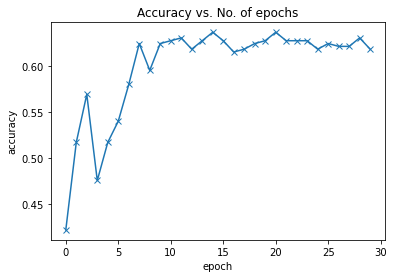

In [48]:
import matplotlib.pyplot as plt

# Plot the history of accuracies
def plot_accuracies(results):
    accuracies = [result['validation_acc'] for result in results]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(results)

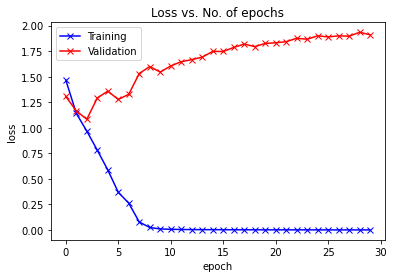

In [49]:
# Plot the losses in each epoch
def plot_losses(results):

    train_losses = [result.get('train_loss') for result in results]
    val_losses = [result['validation_loss'] for result in results]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(results)


In [50]:
test_dataset = FaceMaskDataset(images, test_indexes, conversion=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [51]:
y_true = torch.tensor([])
y_true = y_true.to(device)
y_preds = torch.tensor([])
y_preds = y_preds.to(device)

# test-the-model
model.eval()  # turn off layers like Dropout layers, BatchNorm Layers
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true = torch.cat((y_true, labels))
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_preds = torch.cat((y_preds, predicted))
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

y_true = y_true.to('cpu')
y_preds = y_preds.to('cpu')

Test Accuracy of the model: 62.80193236714976 %


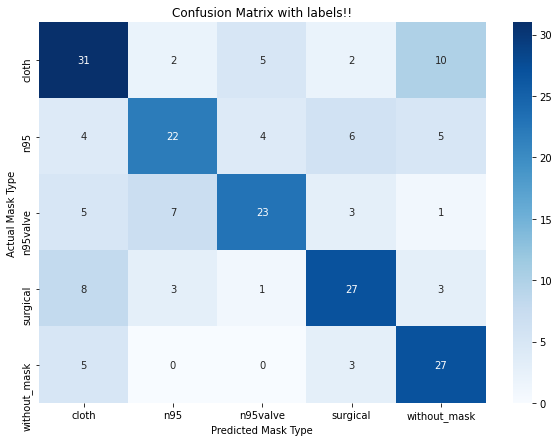

In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# show confusion matrix
def show_confusion_matrix(y_true, y_preds):
    matrix = confusion_matrix(y_true, y_preds)
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(matrix, fmt='', annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix with labels!!');
    ax.set_xlabel('Predicted Mask Type')
    ax.set_ylabel('Actual Mask Type')
    ax.xaxis.set_ticklabels([i for i in classes.keys()])
    ax.yaxis.set_ticklabels([i for i in classes.keys()])
    plt.show()

show_confusion_matrix(y_true, y_preds)


In [53]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_true, y_preds)
print(classification_report(y_true,y_preds))

              precision    recall  f1-score   support

         0.0       0.58      0.62      0.60        50
         1.0       0.65      0.54      0.59        41
         2.0       0.70      0.59      0.64        39
         3.0       0.66      0.64      0.65        42
         4.0       0.59      0.77      0.67        35

    accuracy                           0.63       207
   macro avg       0.63      0.63      0.63       207
weighted avg       0.63      0.63      0.63       207



In [23]:
def label_to_classname(label):
  for classname in classes.keys():
    if classes[classname] == label:
      return classname
  return 'NULL'


In [ ]:
# Put new images at the 'test' directory to classify them
new_images_path = os.path.join(root_folder, "./test")

# get new images
images = os.listdir(new_images_path)

with torch.no_grad():
    for image in images:
      file_name = image
      image = transform(Image.open(os.path.join(new_images_path, image)).convert('RGB'))
      image = image.unsqueeze(0)
      image = image.to(device)
      labels = model(image)
      _, predicted = torch.max(labels.data, 1)
      print(f'{file_name} file is {label_to_classname(predicted[0])}')